In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

2021-10-13 02:44:57.303033: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    
    
    for label in labels:
        DIR = dir_path + label
        #n = 0
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            #while n < size:
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
                
                #n += 1
            
    ## Transform labels in Z to Y from class number
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X, dtype=float)
    X=X/255.
    return X, Y

In [3]:
dir_path = dir_path = '/kaggle/input/auckland-zoo-monkeys/Auckland_Zoo_Monkeys/'

labels = ['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy']

# randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(labels, num_seen):
    arr = np.arange(len(labels))
    np.random.shuffle(arr)
    
    labels_seen = [labels[i] for i in arr[:num_seen]]
    labels_unseen = [labels[i] for i in arr[num_seen:]]
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    Y_unseen = ['unseen'] * len(Y_unseen)
    Y_unseen = np.array(Y_unseen)
    return X_seen, Y_seen, X_unseen, Y_unseen
labels = ['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy']

# randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(labels, num_seen):
    arr = np.arange(len(labels))
    np.random.shuffle(arr)
    
    labels_seen = [labels[i] for i in arr[:num_seen]]
    labels_unseen = [labels[i] for i in arr[num_seen:]]
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    Y_unseen = ['unseen'] * len(Y_unseen)
    Y_unseen = np.array(Y_unseen)
    return X_seen, Y_seen, X_unseen, Y_unseen

# Configuration Settings

In [4]:
imsize = 150
EPOCHS = 10
batch_size = 64
embeddingDim = 128
num_individuals = len(labels)

In [5]:
X_seen, Y_seen, X_unseen, Y_unseen = make_seen_unseen(labels, num_individuals - 1)

100%|██████████| 411/411 [00:03<00:00, 115.64it/s]


# Train/test set split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)

X_val_unseen, X_test_unseen, Y_val_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.5, random_state=2021)

## Exploring the dataset

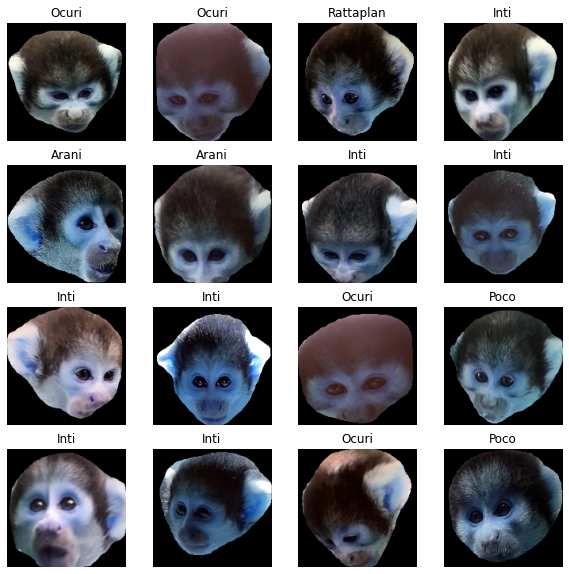

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")

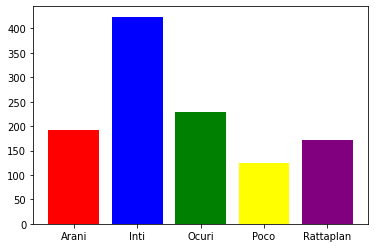

In [8]:
classes, counts = np.unique(Y_train, return_counts = True)

plt.bar(np.array(labels)[classes], counts, color=['red', 'blue', 'green', 'yellow', 'purple'])
plt.show()

# Stratified 5 fold Cross Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)

# VGG16 Classification Model

In [10]:
def evaluate_vgg16(lr):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_vgg_16 = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(units=num_individuals, activation='softmax')
    ])

    model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

    model_vgg_16.fit(x=x_train, y=y_train,
                     epochs=EPOCHS,
                     batch_size=batch_size,
                     verbose=1)
    
    acc = model_vgg_16.evaluate(x_val, y_val)[1]
    
    return acc

In [11]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

terms = {}
for i in lr:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        terms['{}'.format(i)].append(evaluate_vgg16(lr = i))

2021-10-13 02:46:03.629999: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-13 02:46:03.633631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-13 02:46:03.676039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 02:46:03.677104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-13 02:46:03.677158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-13 02:46:03.712796: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 1s 0us/step


2021-10-13 02:46:07.433987: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-13 02:46:07.447210: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/10


2021-10-13 02:46:08.250228: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-13 02:46:09.169586: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-13 02:46:09.196203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


15/15 [==============================] - 12s 117ms/step - loss: 1.6151 - acc: 0.4197
Epoch 2/10
15/15 [==============================] - 1s 63ms/step - loss: 1.3723 - acc: 0.4435
Epoch 3/10
15/15 [==============================] - 1s 63ms/step - loss: 1.2208 - acc: 0.5039
Epoch 4/10
15/15 [==============================] - 1s 62ms/step - loss: 1.1160 - acc: 0.5663
Epoch 5/10
15/15 [==============================] - 1s 61ms/step - loss: 1.0218 - acc: 0.6479
Epoch 6/10
15/15 [==============================] - 1s 63ms/step - loss: 0.9760 - acc: 0.7014
Epoch 7/10
15/15 [==============================] - 1s 67ms/step - loss: 0.8896 - acc: 0.7009
Epoch 8/10
15/15 [==============================] - 1s 64ms/step - loss: 0.7972 - acc: 0.7773
Epoch 9/10
15/15 [==============================] - 1s 63ms/step - loss: 0.7767 - acc: 0.8100
Epoch 10/10
8/8 [==============================] - 2s 77ms/step - loss: 0.8070 - acc: 0.7456
Epoch 1/10
15/15 [==============================] - 2s 64ms/step - los

In [12]:
import pandas as pd
acc = pd.DataFrame(terms)
table_vgg16 = acc.agg(['mean', 'std']).T
table_vgg16

,mean,std
1e-05,0.734211,0.028015
0.0001,0.927193,0.024143
0.001,0.921930,0.023497
0.01,0.922807,0.015692
0.1,0.371930,0.001961


# Retrain VGG16 classification model on training set + val set, test it on test set

In [14]:
# choose best lr
lr = 0.0001 

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=num_individuals, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

model_vgg_16.fit(x=X_train, y=Y_train,
                 epochs=EPOCHS,
                 batch_size=batch_size,
                 verbose=1)

Epoch 1/10
18/18 [==============================] - 4s 196ms/step - loss: 1.5497 - acc: 0.4314
Epoch 2/10
18/18 [==============================] - 1s 66ms/step - loss: 0.7358 - acc: 0.7308
Epoch 3/10
18/18 [==============================] - 1s 65ms/step - loss: 0.4451 - acc: 0.9031
Epoch 4/10
18/18 [==============================] - 1s 66ms/step - loss: 0.3229 - acc: 0.9383
Epoch 5/10
18/18 [==============================] - 1s 65ms/step - loss: 0.2337 - acc: 0.9676
Epoch 6/10
18/18 [==============================] - 1s 66ms/step - loss: 0.1788 - acc: 0.9820
Epoch 7/10
18/18 [==============================] - 1s 64ms/step - loss: 0.1385 - acc: 0.9895
Epoch 8/10
18/18 [==============================] - 1s 65ms/step - loss: 0.1253 - acc: 0.9897
Epoch 9/10
18/18 [==============================] - 1s 67ms/step - loss: 0.0967 - acc: 0.9988
Epoch 10/10
18/18 [==============================] - 1s 65ms/step - loss: 0.0788 - acc: 1.0000


In [15]:
acc_vgg16 = round(model_vgg_16.evaluate(X_test, Y_test)[1], 2)

print('Accuracy of VGG16 on the test set is {}'.format(acc_vgg16))

9/9 [==============================] - 2s 201ms/step - loss: 0.2354 - acc: 0.9231
Accuracy of VGG16 on the test set is 0.92


# Contrastive Loss

In [16]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(num_individuals)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

## Closed Set

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_cl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize,imsize,3),
                                                      weights = 'imagenet')
    
    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
              batch_size = batch_size,
              epochs=EPOCHS, 
              verbose=1)
    
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    x_test_embedding = model_cl.predict(x_val)
    acc = round(knn_cl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the val set with contrastive loss is {}'.format(acc))
    
    return acc

In [18]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [1, 3, 5]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train)
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_cl_closed_set(lr = i, k = j))

Epoch 1/10
29/29 [==============================] - 5s 124ms/step - loss: 0.2419
Epoch 2/10
29/29 [==============================] - 4s 123ms/step - loss: 0.2343
Epoch 3/10
29/29 [==============================] - 4s 123ms/step - loss: 0.2248
Epoch 4/10
29/29 [==============================] - 4s 124ms/step - loss: 0.2151
Epoch 5/10
29/29 [==============================] - 4s 126ms/step - loss: 0.2069
Epoch 6/10
29/29 [==============================] - 4s 125ms/step - loss: 0.1968
Epoch 7/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1871
Epoch 8/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1793
Epoch 9/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1676
Epoch 10/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1601
Accuracy on the val set with contrastive loss is 0.89
Epoch 1/10
29/29 [==============================] - 5s 125ms/step - loss: 0.2472
Epoch 2/10
29/29 [==============================] - 4s

In [19]:
import pandas as pd
acc = pd.DataFrame(terms)
table_cl_closed_set = acc.agg(['mean', 'std']).T
table_cl_closed_set

,mean,std
1e-05_1,0.886,0.016733
1e-05_3,0.866,0.021909
1e-05_5,0.846,0.030496
0.0001_1,0.924,0.023022
0.0001_3,0.924,0.011402
0.0001_5,0.924,0.024083
0.001_1,0.924,0.013416
0.001_3,0.914,0.015166
0.001_5,0.910,0.015811
0.01_1,0.868,0.025884


## Retrain Contrastive Loss on training set + val set, and test it on test set

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# choose best lr and k
lr = 0.0001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1)
    
embedding_train_cl = []
for i in range(len(Y_train)):
        embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
x_test_embedding = model_cl.predict(X_test)
acc_cl_closed_set = round(knn_cl.score(x_test_embedding, Y_test), 2)

print('Accuracy of Constractive Loss on test set is {}'.format(round(acc_cl_closed_set, 2)))

Epoch 1/10
36/36 [==============================] - 9s 226ms/step - loss: 0.2384
Epoch 2/10
36/36 [==============================] - 4s 125ms/step - loss: 0.1630
Epoch 3/10
36/36 [==============================] - 5s 127ms/step - loss: 0.1266
Epoch 4/10
36/36 [==============================] - 4s 125ms/step - loss: 0.0982
Epoch 5/10
36/36 [==============================] - 5s 125ms/step - loss: 0.0759
Epoch 6/10
36/36 [==============================] - 5s 125ms/step - loss: 0.0605
Epoch 7/10
36/36 [==============================] - 4s 124ms/step - loss: 0.0525
Epoch 8/10
36/36 [==============================] - 5s 125ms/step - loss: 0.0433
Epoch 9/10
36/36 [==============================] - 4s 124ms/step - loss: 0.0347
Epoch 10/10
36/36 [==============================] - 5s 125ms/step - loss: 0.0299
Accuracy of Constractive Loss on test set is 0.93


## Open Set

In [21]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_cl_open_set(lr=0.0001, k = 1, d_t = 0.5):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize,imsize,3),
                                                      weights = 'imagenet')
    
    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
              batch_size = batch_size,
              epochs=EPOCHS, 
              verbose=1)
    
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    #find the center point for each class in training set
    support_cl = []
    for i in np.unique(y_train):
        support_cl.append(np.mean(embedding_train_cl[y_train==i], axis=0))
        
    support_cl = np.array(support_cl, dtype=float)
    
    pred = []
    temp_x = np.append(x_val, X_val_unseen, axis=0)
    temp_y = np.append(y_val, Y_val_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_cl.predict(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_cl[j]
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        if min(dists) >= d_t:
            pred.append('unseen')
        else:
            pred.append(knn_cl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the val set with Contrastive Loss is {}'.format(acc_open))
    
    return acc_open

In [22]:
d_t = [0.4, 0.5, 0.6, 0.7, 0.8]

terms = {}
for i in d_t:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train)
    
    for i in d_t:
        terms['{}'.format(i)].append(evaluate_cl_open_set(d_t = i))

Epoch 1/10
29/29 [==============================] - 5s 124ms/step - loss: 0.2485
Epoch 2/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1789
Epoch 3/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1353
Epoch 4/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1012
Epoch 5/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0835
Epoch 6/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0713
Epoch 7/10
29/29 [==============================] - 4s 127ms/step - loss: 0.0576
Epoch 8/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0506
Epoch 9/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0403
Epoch 10/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0334
The accuracy on the val set with Contrastive Loss is 0.71
Epoch 1/10
29/29 [==============================] - 5s 123ms/step - loss: 0.2407
Epoch 2/10
29/29 [==============================] 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 5s 124ms/step - loss: 0.2452
Epoch 2/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1770
Epoch 3/10
29/29 [==============================] - 4s 126ms/step - loss: 0.1264
Epoch 4/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0988
Epoch 5/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0781
Epoch 6/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0661
Epoch 7/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0574
Epoch 8/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0450
Epoch 9/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0410
Epoch 10/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0329
The accuracy on the val set with Contrastive Loss is 0.59
Epoch 1/10
29/29 [==============================] - 5s 127ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 5s 123ms/step - loss: 0.2435
Epoch 2/10
29/29 [==============================] - 4s 126ms/step - loss: 0.1752
Epoch 3/10
29/29 [==============================] - 4s 126ms/step - loss: 0.1308
Epoch 4/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0996
Epoch 5/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0837
Epoch 6/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0665
Epoch 7/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0586
Epoch 8/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0478
Epoch 9/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0411
Epoch 10/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0341


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 5s 123ms/step - loss: 0.2465
Epoch 2/10
29/29 [==============================] - 4s 125ms/step - loss: 0.1885
Epoch 3/10
29/29 [==============================] - 4s 121ms/step - loss: 0.1363
Epoch 4/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1051
Epoch 5/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0865
Epoch 6/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0688
Epoch 7/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0555
Epoch 8/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0483
Epoch 9/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0401
Epoch 10/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0339
The accuracy on the val set with Contrastive Loss is 0.74
Epoch 1/10
29/29 [==============================] - 5s 123ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 5s 126ms/step - loss: 0.2410
Epoch 2/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1733
Epoch 3/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1313
Epoch 4/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1010
Epoch 5/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0795
Epoch 6/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0672
Epoch 7/10
29/29 [==============================] - 4s 121ms/step - loss: 0.0548
Epoch 8/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0475
Epoch 9/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0415
Epoch 10/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0330
The accuracy on the val set with Contrastive Loss is 0.76
Epoch 1/10
29/29 [==============================] - 5s 124ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 5s 123ms/step - loss: 0.2429
Epoch 2/10
29/29 [==============================] - 4s 126ms/step - loss: 0.1751
Epoch 3/10
29/29 [==============================] - 4s 126ms/step - loss: 0.1300
Epoch 4/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1002
Epoch 5/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0796
Epoch 6/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0669
Epoch 7/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0540
Epoch 8/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0459
Epoch 9/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0381
Epoch 10/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0323
The accuracy on the val set with Contrastive Loss is 0.72
Epoch 1/10
29/29 [==============================] - 5s 124ms/step - loss: 

In [23]:
import pandas as pd
acc = pd.DataFrame(terms)
table_cl_open_set = acc.agg(['mean', 'std']).T
table_cl_open_set

,mean,std
0.4,0.704,0.066558
0.5,0.576,0.042778
0.6,0.494,0.011402
0.7,0.392,0.219249
0.8,0.094,0.210190


## Retrain Contrastive Loss on training set + val set, and test it on test set

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# choose the best value of d_t
lr = 0.0001
k = 1
d_t = 0.4

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))

featsA = model_cl(imgA)
featsB = model_cl(imgB)

distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)

model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1)

embedding_train_cl = []
for i in range(len(Y_train)):
    embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])

embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
#find the center point for each class in training set
support_cl = []
for i in np.unique(Y_train):
    support_cl.append(np.mean(embedding_train_cl[Y_train==i], axis=0))
        
support_cl = np.array(support_cl, dtype=float)
    
pred = []
temp_x = np.append(X_test, X_val_unseen, axis=0)
temp_y = np.append(Y_test, Y_val_unseen, axis=0)
    
arr = np.arange(temp_y.shape[0])
np.random.shuffle(arr)
    
temp_x = temp_x[arr]
temp_y = temp_y[arr]
    
for i in range(len(temp_y)):
    dists = []
    for j in range(len(np.unique(Y_train))):
        embedding_test = model_cl.predict(temp_x[i].reshape(1, 150, 150, 3))
        embedding_anchor = support_cl[j]
        dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
        dists.append(dist)
    if min(dists) >= d_t:
            pred.append('unseen')
    else:
        pred.append(knn_cl.predict(embedding_test)[0])

pred = np.array(pred)
    
acc_cl_open_set = round(np.mean(pred == temp_y), 2)
print('The accuracy on the test set with Open Dataset of Contrastive Loss is {}'.format(acc_cl_open_set))

Epoch 1/10
36/36 [==============================] - 6s 125ms/step - loss: 0.2446
Epoch 2/10
36/36 [==============================] - 5s 125ms/step - loss: 0.1714
Epoch 3/10
36/36 [==============================] - 4s 125ms/step - loss: 0.1296
Epoch 4/10
36/36 [==============================] - 4s 124ms/step - loss: 0.1012
Epoch 5/10
36/36 [==============================] - 5s 126ms/step - loss: 0.0784
Epoch 6/10
36/36 [==============================] - 5s 126ms/step - loss: 0.0660
Epoch 7/10
36/36 [==============================] - 4s 124ms/step - loss: 0.0513
Epoch 8/10
36/36 [==============================] - 4s 124ms/step - loss: 0.0434
Epoch 9/10
36/36 [==============================] - 4s 125ms/step - loss: 0.0372
Epoch 10/10
36/36 [==============================] - 5s 126ms/step - loss: 0.0297
The accuracy on the test set with Open Dataset of Contrastive Loss is 0.79


# Triplet Loss

## Closed Set

In [25]:
def evaluate_tl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 
        
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    x_test_embedding = model_tl.predict(x_val)
    acc = round(knn_tl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the the val set with Tripolet Loss is {}'.format(acc))
    
    return acc

In [26]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [1, 3, 5]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []
        
for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_tl_closed_set(lr = i, k = j))

Epoch 1/10
15/15 [==============================] - 3s 64ms/step - loss: 0.9923
Epoch 2/10
15/15 [==============================] - 1s 64ms/step - loss: 0.9903
Epoch 3/10
15/15 [==============================] - 1s 63ms/step - loss: 0.9883
Epoch 4/10
15/15 [==============================] - 1s 61ms/step - loss: 0.9840
Epoch 5/10
15/15 [==============================] - 1s 63ms/step - loss: 0.9761
Epoch 6/10
15/15 [==============================] - 1s 63ms/step - loss: 0.9641
Epoch 7/10
15/15 [==============================] - 1s 62ms/step - loss: 0.9400
Epoch 8/10
15/15 [==============================] - 1s 63ms/step - loss: 0.9147
Epoch 9/10
15/15 [==============================] - 1s 63ms/step - loss: 0.8987
Epoch 10/10
15/15 [==============================] - 1s 65ms/step - loss: 0.8779
Accuracy on the the val set with Tripolet Loss is 0.92
Epoch 1/10
15/15 [==============================] - 2s 63ms/step - loss: 0.9921
Epoch 2/10
15/15 [==============================] - 1s 65ms/step

In [27]:
import pandas as pd
acc = pd.DataFrame(terms)
table_tl_closed_set = acc.agg(['mean', 'std']).T
table_tl_closed_set

,mean,std
1e-05_1,0.910,0.018708
1e-05_3,0.876,0.023022
1e-05_5,0.864,0.015166
0.0001_1,0.932,0.013038
0.0001_3,0.936,0.023022
0.0001_5,0.922,0.014832
0.001_1,0.946,0.011402
0.001_3,0.934,0.018166
0.001_5,0.938,0.013038
0.01_1,0.848,0.042071


## Retrain Triplet Loss on training set + val set, and test it on test set

In [28]:
# choose best lr and k
lr = 0.001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
        layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x=X_train, y= Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
x_test_embedding = model_tl.predict(X_test)
acc_tl_closed_set = round(knn_tl.score(x_test_embedding, Y_test), 2)

print('Accuracy of Triplet Loss on the test set is {}'.format(round(acc_tl_closed_set, 2)))

Epoch 1/10
18/18 [==============================] - 2s 66ms/step - loss: 0.9809
Epoch 2/10
18/18 [==============================] - 1s 66ms/step - loss: 0.9227
Epoch 3/10
18/18 [==============================] - 1s 67ms/step - loss: 0.9344
Epoch 4/10
18/18 [==============================] - 1s 66ms/step - loss: 0.6446
Epoch 5/10
18/18 [==============================] - 1s 67ms/step - loss: 0.7746
Epoch 6/10
18/18 [==============================] - 1s 66ms/step - loss: 0.4606
Epoch 7/10
18/18 [==============================] - 1s 66ms/step - loss: 0.3741
Epoch 8/10
18/18 [==============================] - 1s 68ms/step - loss: 0.4292
Epoch 9/10
18/18 [==============================] - 1s 66ms/step - loss: 0.3721
Epoch 10/10
18/18 [==============================] - 1s 65ms/step - loss: 0.2620
Accuracy of Triplet Loss on the test set is 0.94


## Open Set

In [29]:
def evaluate_tl_open_set(lr = 0.001, k = 1, d_t =0.5):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 
        
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    #find the center point for each class in training set
    support_tl = []
    for i in np.unique(y_train):
        support_tl.append(np.mean(embedding_train_tl[y_train==i], axis=0))
        
    support_tl = np.array(support_tl, dtype=float)
    
    pred = []
    temp_x = np.append(x_val, X_unseen, axis=0)
    temp_y = np.append(y_val, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_tl.predict(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_tl[j]
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        if min(dists) >= d_t:
            pred.append('unseen')
        else:
            pred.append(knn_tl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Open Dataset with triplet loss is {}'.format(acc_open))
    
    return acc_open

In [30]:
d_t = [0.4, 0.5, 0.6, 0.7, 0.8]

terms = {}
for i in d_t:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in d_t:
        terms['{}'.format(i)].append(evaluate_tl_open_set(d_t = i))

Epoch 1/10
15/15 [==============================] - 2s 64ms/step - loss: 0.9725
Epoch 2/10
15/15 [==============================] - 1s 63ms/step - loss: 0.8500
Epoch 3/10
15/15 [==============================] - 1s 63ms/step - loss: 0.7344
Epoch 4/10
15/15 [==============================] - 1s 63ms/step - loss: 0.6341
Epoch 5/10
15/15 [==============================] - 1s 63ms/step - loss: 0.5319
Epoch 6/10
15/15 [==============================] - 1s 64ms/step - loss: 0.5822
Epoch 7/10
15/15 [==============================] - 1s 63ms/step - loss: 0.3480
Epoch 8/10
15/15 [==============================] - 1s 63ms/step - loss: 0.3129
Epoch 9/10
15/15 [==============================] - 1s 66ms/step - loss: 0.2642
Epoch 10/10
15/15 [==============================] - 1s 62ms/step - loss: 0.2065
The accuracy on the Open Dataset with triplet loss is 0.74
Epoch 1/10
15/15 [==============================] - 2s 65ms/step - loss: 0.9745
Epoch 2/10
15/15 [==============================] - 1s 64ms/

In [31]:
import pandas as pd
acc = pd.DataFrame(terms)
table_tl_open_set = acc.agg(['mean', 'std']).T
table_tl_open_set

,mean,std
0.4,0.784,0.032094
0.5,0.712,0.094181
0.6,0.640,0.065192
0.7,0.518,0.074967
0.8,0.462,0.036332


## Retrain Triplet Loss on training set + val set, and test it on test set

In [32]:
lr = 0.001
k = 1
d_t = 0.4


base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x = X_train, y = Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
#find the center point for each class in training set
support_tl = []
for i in np.unique(Y_train):
    support_tl.append(np.mean(embedding_train_tl[Y_train==i], axis=0))
        
support_tl = np.array(support_tl, dtype=float)
    
pred = []
temp_x = np.append(X_test, X_unseen, axis=0)
temp_y = np.append(Y_test, Y_unseen, axis=0)
    
arr = np.arange(temp_y.shape[0])
np.random.shuffle(arr)
    
temp_x = temp_x[arr]
temp_y = temp_y[arr]
    
for i in range(len(temp_y)):
    dists = []
    for j in range(len(np.unique(Y_train))):
        embedding_test = model_tl.predict(temp_x[i].reshape(1, 150, 150, 3))
        embedding_anchor = support_tl[j]
        dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
        dists.append(dist)
    if min(dists) >= d_t:
        pred.append('unseen')
    else:
        pred.append(knn_tl.predict(embedding_test)[0])

pred = np.array(pred)
    
acc_tl_open_set = round(np.mean(pred == temp_y), 2)
print('The accuracy on the test set with Open Dataset of Triplet Loss is {}'.format(acc_tl_open_set))

Epoch 1/10
18/18 [==============================] - 2s 68ms/step - loss: 0.9678
Epoch 2/10
18/18 [==============================] - 1s 74ms/step - loss: 0.8348
Epoch 3/10
18/18 [==============================] - 1s 66ms/step - loss: 0.6450
Epoch 4/10
18/18 [==============================] - 1s 66ms/step - loss: 0.6819
Epoch 5/10
18/18 [==============================] - 1s 67ms/step - loss: 0.5334
Epoch 6/10
18/18 [==============================] - 1s 66ms/step - loss: 0.4012
Epoch 7/10
18/18 [==============================] - 1s 66ms/step - loss: 0.3189
Epoch 8/10
18/18 [==============================] - 1s 66ms/step - loss: 0.2964
Epoch 9/10
18/18 [==============================] - 1s 65ms/step - loss: 0.2315
Epoch 10/10
18/18 [==============================] - 1s 66ms/step - loss: 0.1642
The accuracy on the test set with Open Dataset of Triplet Loss is 0.83


# Summary on Closed Set

In [33]:
# After tuning hps (lr and k), the best accuracy on val set.
best_vgg16 = table_vgg16.loc['0.0001']
best_cl = table_cl_closed_set.loc['0.0001_1']
best_tl = table_tl_closed_set.loc['0.001_1']

pd.DataFrame({'VGG16_(LR = 0.0001)': best_vgg16,
              'Contrastive_Loss(LR = 0.0001, k = 1)': best_cl, 
              'Triplet_Loss(LR = 0.001, k = 1)': best_tl
             })

,VGG16_(LR = 0.0001),"Contrastive_Loss(LR = 0.0001, k = 1)","Triplet_Loss(LR = 0.001, k = 1)"
mean,0.927193,0.924000,0.946000
std,0.024143,0.023022,0.011402


In [34]:
# Accuracy on test set

pd.DataFrame([acc_vgg16, acc_cl_closed_set, acc_tl_closed_set], index = ['VGG16', 'Contrastive_Loss', 'Triplet_Loss'], columns = ['Accuracy']).T

,VGG16,Contrastive_Loss,Triplet_Loss
Accuracy,0.92,0.93,0.94


# Summary on Open Set

In [35]:
# After tuning hps (d_t), the best accuracy on val set.

best_cl = table_cl_open_set.loc['0.4']
best_tl = table_tl_open_set.loc['0.4']

pd.DataFrame({'Contrastive_Loss(d_t = 0.4)': best_cl, 
              'Triplet_Loss(d_t = 0.4)': best_tl
             })

,Contrastive_Loss(d_t = 0.4),Triplet_Loss(d_t = 0.4)
mean,0.704000,0.784000
std,0.066558,0.032094


In [36]:
# Accuracy on test set

pd.DataFrame([acc_cl_open_set, acc_tl_open_set], index = ['Contrastive_Loss', 'Triplet_Loss'], columns = ['Accuracy']).T

,Contrastive_Loss,Triplet_Loss
Accuracy,0.79,0.83


# Mis-classified monkeys

## VGG16 Classification Model

In [37]:
# choose best lr
lr = 0.0001 

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=num_individuals, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

model_vgg_16.fit(x=X_train, y=Y_train,
                 epochs=EPOCHS,
                 batch_size=batch_size,
                 verbose=1)

Epoch 1/10
18/18 [==============================] - 2s 66ms/step - loss: 1.5968 - acc: 0.3734
Epoch 2/10
18/18 [==============================] - 1s 67ms/step - loss: 0.7338 - acc: 0.7582
Epoch 3/10
18/18 [==============================] - 1s 67ms/step - loss: 0.4723 - acc: 0.8827
Epoch 4/10
18/18 [==============================] - 1s 65ms/step - loss: 0.3324 - acc: 0.9385
Epoch 5/10
18/18 [==============================] - 1s 66ms/step - loss: 0.2449 - acc: 0.9611
Epoch 6/10
18/18 [==============================] - 1s 69ms/step - loss: 0.1876 - acc: 0.9861
Epoch 7/10
18/18 [==============================] - 1s 64ms/step - loss: 0.1401 - acc: 0.9941
Epoch 8/10
18/18 [==============================] - 1s 65ms/step - loss: 0.1246 - acc: 0.9938
Epoch 9/10
18/18 [==============================] - 1s 65ms/step - loss: 0.0987 - acc: 0.9995
Epoch 10/10
18/18 [==============================] - 1s 64ms/step - loss: 0.0812 - acc: 0.9965


In [38]:
pred = model_vgg_16.predict_classes(X_test)

monkeys, mis_classes = np.unique(Y_test[pred != Y_test], return_counts=True)
pd.DataFrame({'monkeys': np.array(labels)[monkeys], 'mis_classfied': mis_classes})

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,monkeys,mis_classfied
0,Arani,5
1,Inti,5
2,Ocuri,1
3,Poco,2
4,Rattaplan,6


## Contrastive Loss

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# choose best lr and k
lr = 0.0001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1)
    
embedding_train_cl = []
for i in range(len(Y_train)):
        embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
x_test_embedding = model_cl.predict(X_test)
pred = knn_cl.predict(x_test_embedding)

Epoch 1/10
36/36 [==============================] - 6s 125ms/step - loss: 0.2407
Epoch 2/10
36/36 [==============================] - 5s 127ms/step - loss: 0.1606
Epoch 3/10
36/36 [==============================] - 4s 124ms/step - loss: 0.1199
Epoch 4/10
36/36 [==============================] - 5s 126ms/step - loss: 0.0948
Epoch 5/10
36/36 [==============================] - 4s 125ms/step - loss: 0.0759
Epoch 6/10
36/36 [==============================] - 5s 125ms/step - loss: 0.0653
Epoch 7/10
36/36 [==============================] - 5s 127ms/step - loss: 0.0503
Epoch 8/10
36/36 [==============================] - 5s 126ms/step - loss: 0.0442
Epoch 9/10
36/36 [==============================] - 5s 126ms/step - loss: 0.0352
Epoch 10/10
36/36 [==============================] - 5s 126ms/step - loss: 0.0306


In [40]:
monkeys, mis_classes = np.unique(Y_test[pred != Y_test], return_counts=True)
pd.DataFrame({'monkeys': np.array(labels)[monkeys], 'mis_classfied': mis_classes})

,monkeys,mis_classfied
0,Arani,2
1,Inti,5
2,Ocuri,1
3,Poco,1
4,Rattaplan,6


## Triplet Loss

In [41]:
# choose best lr and k
lr = 0.001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
        layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x=X_train, y= Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
x_test_embedding = model_tl.predict(X_test)
pred = knn_tl.predict(x_test_embedding)

Epoch 1/10
18/18 [==============================] - 2s 66ms/step - loss: 0.9635
Epoch 2/10
18/18 [==============================] - 1s 65ms/step - loss: 0.8011
Epoch 3/10
18/18 [==============================] - 1s 66ms/step - loss: 0.6328
Epoch 4/10
18/18 [==============================] - 1s 66ms/step - loss: 0.7036
Epoch 5/10
18/18 [==============================] - 1s 69ms/step - loss: 0.5363
Epoch 6/10
18/18 [==============================] - 1s 66ms/step - loss: 0.4775
Epoch 7/10
18/18 [==============================] - 1s 66ms/step - loss: 0.5072
Epoch 8/10
18/18 [==============================] - 1s 66ms/step - loss: 0.3152
Epoch 9/10
18/18 [==============================] - 1s 66ms/step - loss: 0.2378
Epoch 10/10
18/18 [==============================] - 1s 66ms/step - loss: 0.1684


In [42]:
monkeys, mis_classes = np.unique(Y_test[pred != Y_test], return_counts=True)
pd.DataFrame({'monkeys': np.array(labels)[monkeys], 'mis_classfied': mis_classes})

,monkeys,mis_classfied
0,Arani,5
1,Inti,4
2,Ocuri,1
3,Poco,3
4,Rattaplan,4
